# Selecting cutoffs
Selecting cutoffs for a CE can typically be done by systematically increasing cutoffs and checking the RMSE over the validation set or an information criterion.
A simple approach is to first scan the second order cutoff, find the optimal second order cutoff, use this to scan the third order cutoff and so on.

We also recommend that once cutoffs are scanned to go back and rescan, e.g., the second order cutoff using the finalized cutoffs for the third and fourth order because this might lead to a slightly different optimal choice than the previous scans.

The scans can take more or less time depending on fitting algorithm and how densely one scans the cutoffs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ase.db import connect
from icet import ClusterSpace, StructureContainer
from trainstation import CrossValidationEstimator

## Setup

We define some convenience functions.

In [2]:
def get_fit_data(cutoffs):
    """
    Construct cluster space and structure container for the given cutoffs
    and return the fit matrix along with the target energies
    """
    cs = ClusterSpace(structure=primitive_structure,
                      cutoffs=cutoffs,
                      chemical_symbols=['Ag', 'Pd'])

    sc = StructureContainer(cluster_space=cs)
    for row in db.select():
        sc.add_structure(structure=row.toatoms(),
                         user_tag=row.tag,
                         properties={'mixing_energy': row.mixing_energy})
    return sc.get_fit_data(key='mixing_energy')


def train_ce(cutoffs):
    """
    Train a cluster expansion with the given cutoffs and return fit metrics of the obtained model.
    """
    A, y = get_fit_data(cutoffs)
    cve = CrossValidationEstimator((A, y), fit_method=fit_method,
                                   validation_method='shuffle-split', n_splits=100)
    cve.validate()
    cve.train()

    row = dict()
    row['rmse_validation'] = cve.rmse_validation
    row['rmse_train'] = cve.rmse_train
    row['BIC'] = cve.model.BIC
    row['n_parameters'] = cve.n_parameters
    row['n_nonzero_parameters'] = cve.n_nonzero_parameters

    return row

Now we set some general parameters.
The `cN_vals` variables specify the cutoff range for orbits of order `N`, where `N=2` are pairs, `N=3` are triplets, and so on.

In [3]:
# parameters
fit_method = 'least-squares'
c2_vals = np.arange(4.0, 15.01, 0.5)
c3_vals = np.arange(4.0, 8.0, 0.5)
c4_vals = np.arange(4.0, 7.5, 0.5)

# retrieve the primitive structure
db = connect('../../tutorial/reference_data.db')
primitive_structure = db.get(id=1).toatoms()

## Scan pair cutoff

First we scan the cutoff for the second order (i.e., pairs) and find a good value of about 9 Å.

In [4]:
%%time
records = []
for c2 in c2_vals:
    cutoffs = [c2]
    row = train_ce(cutoffs)
    records.append({'c2': c2, **row})

df2 = pd.DataFrame(records)
c2_final = 8.0

CPU times: user 33.1 s, sys: 24.3 s, total: 57.3 s
Wall time: 26.4 s


## Plot results of pair cutoff scan

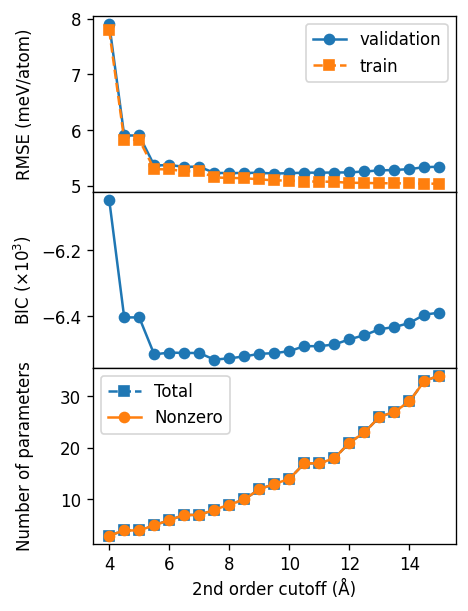

In [5]:
fig, axes = plt.subplots(
    figsize=(4, 5.2),
    dpi=120,
    sharex=True,
    nrows=3,
)

ax = axes[0]
conv = 1000
ax.plot(df2.c2, conv * df2.rmse_validation, '-o', label='validation')
ax.plot(df2.c2, conv * df2.rmse_train, '--s', label='train')
ax.set_ylabel('RMSE (meV/atom)')
ax.legend()

ax = axes[1]
ax.plot(df2.c2, 1e-3 * df2.BIC, '-o')
ax.set_ylabel(r'BIC ($\times 10^{3}$)')

ax = axes[2]
ax.plot(df2.c2, df2.n_parameters, '--s', label='Total')
ax.plot(df2.c2, df2.n_nonzero_parameters, '-o', label='Nonzero')
ax.set_xlabel('2nd order cutoff (Å)')
ax.set_ylabel('Number of parameters')
ax.legend()

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.align_ylabels(axes)

## Third-order cutoff
For the third-order cutoff we find a value of about 6.5 Å.

In [6]:
records = []
for c3 in c3_vals:
    cutoffs = [c2_final, c3]
    row = train_ce(cutoffs)
    records.append({'c2': c2_final, 'c3': c3, **row})

df3 = pd.DataFrame(records)
c3_final = 6.5

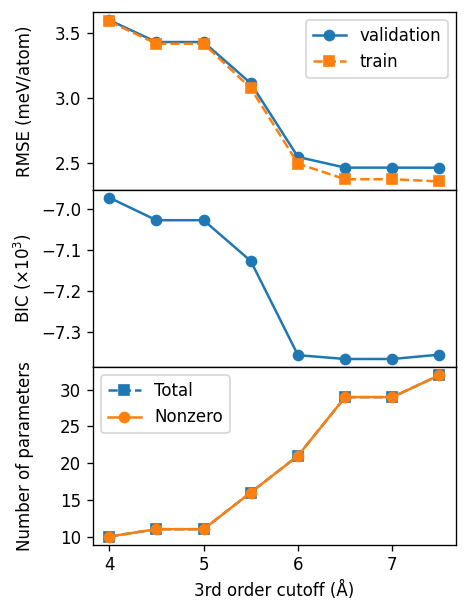

In [7]:
fig, axes = plt.subplots(
    figsize=(4, 5.2),
    dpi=120,
    sharex=True,
    nrows=3,
)

ax = axes[0]
conv = 1000
ax.plot(df3.c3, conv * df3.rmse_validation, '-o', label='validation')
ax.plot(df3.c3, conv * df3.rmse_train, '--s', label='train')
ax.set_ylabel('RMSE (meV/atom)')
ax.legend()

ax = axes[1]
ax.plot(df3.c3, 1e-3 * df3.BIC, '-o')
ax.set_ylabel(r'BIC ($\times 10^{3}$)')

ax = axes[2]
ax.plot(df3.c3, df3.n_parameters, '--s', label='Total')
ax.plot(df3.c3, df3.n_nonzero_parameters, '-o', label='Nonzero')
ax.set_xlabel('3rd order cutoff (Å)')
ax.set_ylabel('Number of parameters')
ax.legend()

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.align_ylabels(axes)

## Fourth-order cutoff
For the fourth-order cutoff we find a value of about 6.0 Å.
We note that for fourth-order cutoffs above 6.5 Å we get a condition number warning, which indicates that the linear problem we are solving is ill conditioned and thus we cannot trust the resulting cluster expansion for these cutoffs.

In [8]:
records = []
for c4 in c4_vals:
    cutoffs = [c2_final, c3_final, c4]
    row = train_ce(cutoffs)
    records.append({'c2': c2_final, 'c3': c3_final, 'c4': c4, **row})

df4 = pd.DataFrame(records)
c4_final = 6.0

Condition number is large, [... repeated ...]


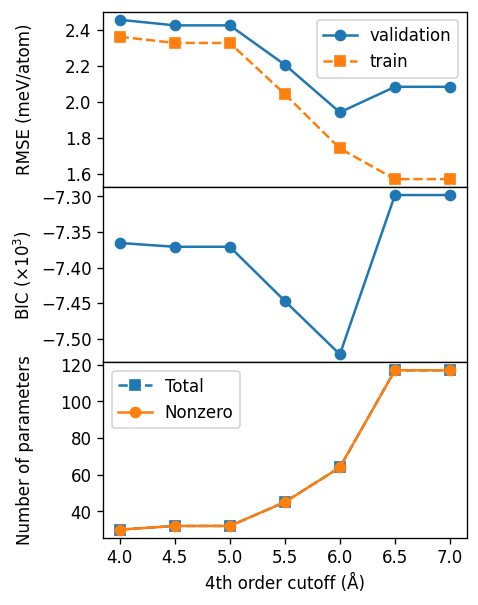

In [9]:
fig, axes = plt.subplots(
    figsize=(4, 5.2),
    dpi=120,
    sharex=True,
    nrows=3,
)

ax = axes[0]
conv = 1000
ax.plot(df4.c4, conv * df4.rmse_validation, '-o', label='validation')
ax.plot(df4.c4, conv * df4.rmse_train, '--s', label='train')
ax.set_ylabel('RMSE (meV/atom)')
ax.legend()

ax = axes[1]
ax.plot(df4.c4, 1e-3 * df4.BIC, '-o')
ax.set_ylabel(r'BIC ($\times 10^{3}$)')

ax = axes[2]
ax.plot(df4.c4, df4.n_parameters, '--s', label='Total')
ax.plot(df4.c4, df4.n_nonzero_parameters, '-o', label='Nonzero')
ax.set_xlabel('4th order cutoff (Å)')
ax.set_ylabel('Number of parameters')
ax.legend()

fig.tight_layout()
fig.subplots_adjust(hspace=0)
fig.align_ylabels(axes)